
# Welcome
> This project about the first project in the ADAND 

In [2]:
# Importing the main packages
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
dataset_dir = r'D:\Google Drive\FWD Advanced Data Analysis Course\Projects\Project 1 - Investigate Data\Datasets'
df = pd.read_csv(rf'{dataset_dir}\tmdb-movies.csv', encoding="utf-8")
df ['profit'] = df['revenue_adj'] - df['budget_adj']
df.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,profit
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09,1.254446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08,2.101614e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08,1.704191e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09,1.718723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09,1.210949e+09


>  **Columns:** cast, genres, production_companie include multiple values for the same row. 

In [3]:
## show the columns with NAs data
df.isna().sum() 

id                         0
imdb_id                   10
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
homepage                7930
director                  44
tagline                 2824
keywords                1493
overview                   4
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
profit                     0
dtype: int64

## Filling the nulls of the genres with the most frequent genre for each director

In [138]:
# At first find out how many null will be filled by using this approach
df[df['genres'].isna()].director.isna().sum()

2

In [4]:
# data with non-english characters
df[df.original_title.str.contains(r'[^\x00-\x7F]+', regex=True)]['original_title']

424              Belli di papÃ 
471              è§£æ•‘å´å…ˆç”Ÿ
702                   AutÃ³mata
758            Suite FranÃ§aise
848      Sheâ€™s Funny That Way
                  ...          
10497           Â¡Three Amigos!
10518                 DÃ¨moni 2
10575               MacskafogÃ³
10634    VÃ©ritÃ©s et Mensonges
10751             DoppelgÃ¤nger
Name: original_title, Length: 207, dtype: object

## Data Wrangling

### Removing duplicates 

In [52]:
# get the number of duplicated rows.
df.duplicated().sum()

1

> Only one movie is repeated twice

In [54]:
# drop the duplicated rows
df.drop_duplicates(ignore_index=True, inplace=True)

### Changing the datatypes

In [5]:
# Transforming the release_date column to date object
df['release_date'] = pd.to_datetime(df['release_date'])


# handle the dates from teh 20th century.
df.loc[df['release_date'].dt.year>2018, 'release_date']  -= pd.DateOffset(years=100) 

# Make sure all the relaste date are properly converted
(df['release_date'].dt.year == df['release_year']).all()

# Get all the columns that have non-ascii characters, that may affect the analysis
non_ascii_columns = []

for col in df.select_dtypes(object):
    if df[col].str.contains(r'[^\x00-\x7F]+', regex=True).any(axis=0):
        non_ascii_columns.append(col)
non_ascii_columns        
# check for non-ascii characters

# print(df[df['original_title'].str.contains(r'[^\x00-\x7F]+', regex=True)])

# df.dropna(axis=0, inplace=True , subset=['cast'])

# df[df['cast'].str.contains(r'[^\x00-\x7F]+', regex=True)] ['cast'].str.split('/').head(50)

['original_title',
 'cast',
 'homepage',
 'director',
 'tagline',
 'keywords',
 'overview',
 'production_companies']

### Denormalizing the data, and breaking the columns with multiple values

In [5]:
## this function to break the row that contains composite column into multiple rows 
def denormalize_data (df, col, sep=r'\|' ):
    if df[col].str.contains(sep).any():
        df['temp'] = df[col].str.split(sep)
        denormalized_df =  df.explode('temp', ignore_index=True)
        df.drop(columns='temp', inplace = True)
        denormalized_df[col] = denormalized_df['temp'] 
        denormalized_df.drop(columns='temp', inplace = True)
        return denormalized_df

In [220]:
# Denormalize & split the multivalue columns
## split_columns = ['cast', 'genres', 'production_companies']

genre_df= denormalize_data( df,'genres')

director_df = denormalize_data(genre_df, 'director').loc[: , ['id','director', 'genres']]


In [226]:
genre_df.loc[:, ['id', 'genres']].duplicated().sum()

0

In [356]:
genre_df[genre_df['genres'].isna()].profit.sum()/genre_df.profit.sum() * 100

-2.61428864176124e-06

In [215]:
# eleminating the movies with no directors
director_df.dropna(inplace=True, subset=['director'])

In [209]:
director_df[director_df['director'].str.contains('Danny Boyle', na=False)]

,id,director,genres
136,321697,Danny Boyle,History
137,321697,Danny Boyle,Drama
4910,44115,Danny Boyle,Adventure
4911,44115,Danny Boyle,Drama
4912,44115,Danny Boyle,Thriller
7692,12405,Danny Boyle,Drama
7694,12405,Danny Boyle,Romance
10463,170,Danny Boyle,Horror
10464,170,Danny Boyle,Thriller
10465,170,Danny Boyle,Science Fiction


In [219]:
director_df[director_df['director'].str.contains('Danny Boyle', na=False)]

,id,director,genres,most_frequent_genre
136,321697,Danny Boyle,History,Drama
137,321697,Danny Boyle,Drama,Drama
4910,44115,Danny Boyle,Adventure,Drama
4911,44115,Danny Boyle,Drama,Drama
4912,44115,Danny Boyle,Thriller,Drama
7692,12405,Danny Boyle,Drama,Drama
7694,12405,Danny Boyle,Romance,Drama
10463,170,Danny Boyle,Horror,Drama
10464,170,Danny Boyle,Thriller,Drama
10465,170,Danny Boyle,Science Fiction,Drama


In [199]:
movies_genre_df = director_df.loc[:, ['id', 'most_frequent_genre']].drop_duplicates(ignore_index=True)
# movies_genre_df[movies_genre_df.id.duplicated()]
movies_genre_df.duplicated().sum()

# [movies_genre_df.set_index('id')['most_frequent_genre'].duplicated()]

# genre_df.set_index('id')['genres'].fillna(movies_genre_df.set_index('id')['most_frequent_genre'])
# genre_df.genres.fillna(value=movies_genre_df[''], alis)

0

In [216]:
director_df['most_frequent_genre'] = director_df.groupby('director')['genres'].transform(lambda x: x.mode(dropna=False)[0])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\algorithms.py:944: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'float'
  warn(f"Unable to sort modes: {err}")


In [217]:
director_df['most_frequent_genre'].isna().sum()

35

In [22]:
# director_df['genres'] = director_df[(~director_df['director'].isna())&(~director_df['genres'].isna()) ].groupby('director')['genres'].apply(lambda x: x.fillna(x.mode()[0]))



# director_df['genres'] = 

# director_df[director_df['director'].notna()]['genres'] = 
temp =director_df[director_df['director'].notna()].groupby(by='director')['genres'].transform(lambda x: x.fillna(x.mode()[0] if x.mode().size>0 else x.mode()))
temp

# director_df[director_df['director'].notna()]['genres'].isna().sum()


0                 Action
1              Adventure
2        Science Fiction
3               Thriller
4                 Action
              ...       
29574            Mystery
29575             Comedy
29576             Action
29577             Comedy
29578             Horror
Name: genres, Length: 29486, dtype: object

In [10]:
genre_df['genres'].isna().sum()

23

> After replicating the movies based on the genres they have, there are 23 movies without a genre.

In [11]:
df.sort_values(by='popularity', ascending=False)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,profit
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,2015-06-09,5562,6.5,2015,1.379999e+08,1.392446e+09,1.254446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,2015-05-13,6185,7.1,2015,1.379999e+08,3.481613e+08,2.101614e+08
629,157336,tt0816692,24.949134,165000000,621752480,Interstellar,Matthew McConaughey|Jessica Chastain|Anne Hath...,http://www.interstellarmovie.net/,Christopher Nolan,Mankind was born on Earth. It was never meant ...,...,169,Adventure|Drama|Science Fiction,Paramount Pictures|Legendary Pictures|Warner B...,2014-11-05,6498,8.0,2014,1.519800e+08,5.726906e+08,4.207106e+08
630,118340,tt2015381,14.311205,170000000,773312399,Guardians of the Galaxy,Chris Pratt|Zoe Saldana|Dave Bautista|Vin Dies...,http://marvel.com/guardians,James Gunn,All heroes start somewhere.,...,121,Action|Science Fiction|Adventure,Marvel Studios|Moving Picture Company (MPC)|Bu...,2014-07-30,5612,7.9,2014,1.565855e+08,7.122911e+08,5.557057e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,2015-03-18,2480,6.3,2015,1.012000e+08,2.716190e+08,1.704191e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6961,15412,tt0466460,0.001115,0,0,Khosla Ka Ghosla!,Anupam Kher|Boman Irani|Parvin Dabas|Tara Shar...,NaN,Dibakar Banerjee,A Delhi-based retired middle class man tries t...,...,135,Comedy,UTV Motion Pictures,2006-09-22,10,6.8,2006,0.000000e+00,0.000000e+00,0.000000e+00
6551,31329,tt0445570,0.000973,0,0,Mon petit doigt m'a dit...,Catherine Frot|AndrÃ© Dussollier|GeneviÃ¨ve Bu...,NaN,Pascal Thomas,NaN,...,105,Comedy|Mystery,RhÃ´ne-Alpes CinÃ©ma|France2 CinÃ©ma,2005-04-13,13,5.7,2005,0.000000e+00,0.000000e+00,0.000000e+00
6080,174323,tt2429074,0.000620,0,0,G.B.F.,Michael J. Willett|Paul Iacono|Sasha Pieterse|...,https://www.facebook.com/GBFmovie,Darren Stein,Being out has never been so in.,...,92,Comedy,School Pictures|Parting Shots Media|Logolite E...,2013-10-20,82,6.1,2013,0.000000e+00,0.000000e+00,0.000000e+00
9977,32082,tt0067217,0.000188,0,0,The Hospital,George C. Scott|Diana Rigg|Richard Dysart|Barn...,NaN,Arthur Hiller,"Madness, Murder and Malpractice.",...,103,Mystery|Comedy|Drama,Simcha Productions,1971-12-14,10,6.4,1971,0.000000e+00,0.000000e+00,0.000000e+00


# Questions
## Q1) What was the most movies genres porfitable over the years?


In [243]:
genre_summary = genre_df.loc[:  , ['release_year','genres','vote_count', 'vote_average', 'profit']].groupby(as_index= False, by=['release_year','genres']).agg({'vote_count': 'sum', 'vote_average': 'mean', 'profit': 'sum'}).sort_values(by=['release_year','profit'], ascending=[True, False], ignore_index=True)


genre_summary.duplicated().sum()
genre_summary.loc[:, ['release_year', 'genres']].duplicated().sum()


0

## Showing Top Genres

#### Showing the top Geners over all the period

In [286]:
genre_summary.groupby('genres', as_index=False)['profit'].sum().sort_values(by='profit', ascending=False, ignore_index= True) #.apply( lambda x: '${}B'.format(round(x/1000000000, 1))).to_frame()

,genres,profit
0,Adventure,1.437724e+11
1,Action,1.401748e+11
2,Drama,1.216828e+11
3,Comedy,1.212876e+11
4,Thriller,1.005913e+11
5,Family,7.486058e+10
6,Science Fiction,7.061113e+10
7,Fantasy,6.760523e+10
8,Romance,5.571019e+10
9,Crime,4.752932e+10


In [316]:
genre_summary[genre_summary['genres'].str.contains ('|'.join(top_genres))]

,release_year,genres,vote_count,vote_average,profit
0,1960,Drama,1796,6.276923,7.903309e+08
1,1960,Action,527,6.050000,3.753209e+08
3,1960,Comedy,359,6.312500,3.101807e+08
6,1960,Thriller,1414,6.816667,2.224649e+08
9,1960,Adventure,410,6.680000,1.588874e+07
...,...,...,...,...,...
1030,2015,Adventure,71381,6.075362,9.191130e+09
1031,2015,Action,73669,5.629907,8.898878e+09
1033,2015,Thriller,58722,5.471345,5.170966e+09
1034,2015,Comedy,48581,6.019136,5.023215e+09


In [374]:
def get_top_genres (measure):
    return genre_summary.groupby('genres', as_index=False)[measure].sum().sort_values(by=measure, ascending=False, ignore_index= True)['genres'][0:3].tolist()



def trend_lines (measure, genres_list=None):
    color= {'C0', 'C1', 'C2', 'C3', 'C4', 'C5'}
    top_genres  = get_top_genres(measure) if genres_list is None else genres_list 
    df = genre_summary[genre_summary['genres'].str.contains ('|'.join(top_genres))]
    all_genres= df['genres'].unique().tolist()
   
    fig, ax = plt.subplots(figsize=(18,8))
    for i in all_genres:
        x = df[df['genres'].str.contains(i)] ['release_year'].tolist()
        y = df[df['genres'].str.contains(i)][measure].tolist()
        plt.scatter(x, y)
        plt.plot(x,y, label= i, linewidth=3)
    
    plt.title("The {} of top genres over years".format( measure))
    plt.ylabel("Measure")
    plt.xlabel("Release Years")
    plt.legend()
    plt.grid()
    plt.xticks(rotation = 0)
    plt.show()

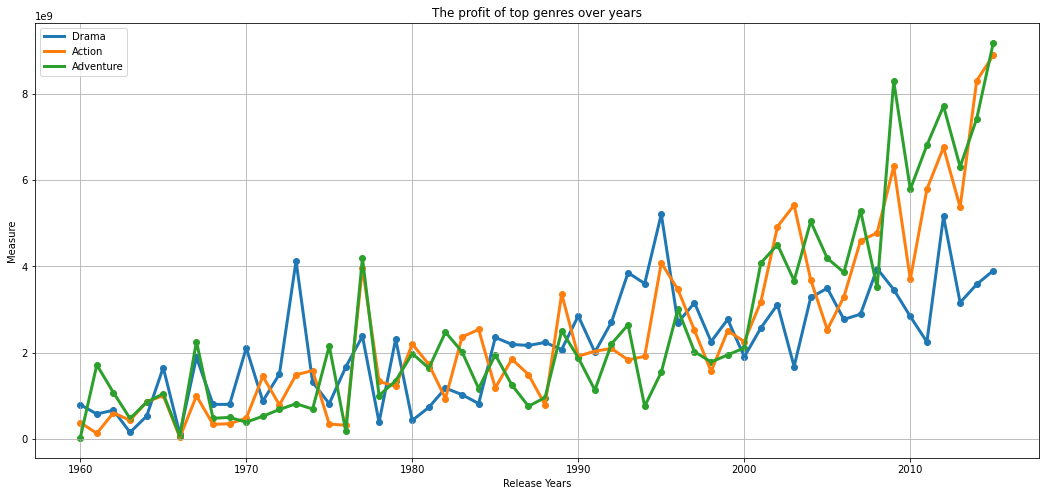

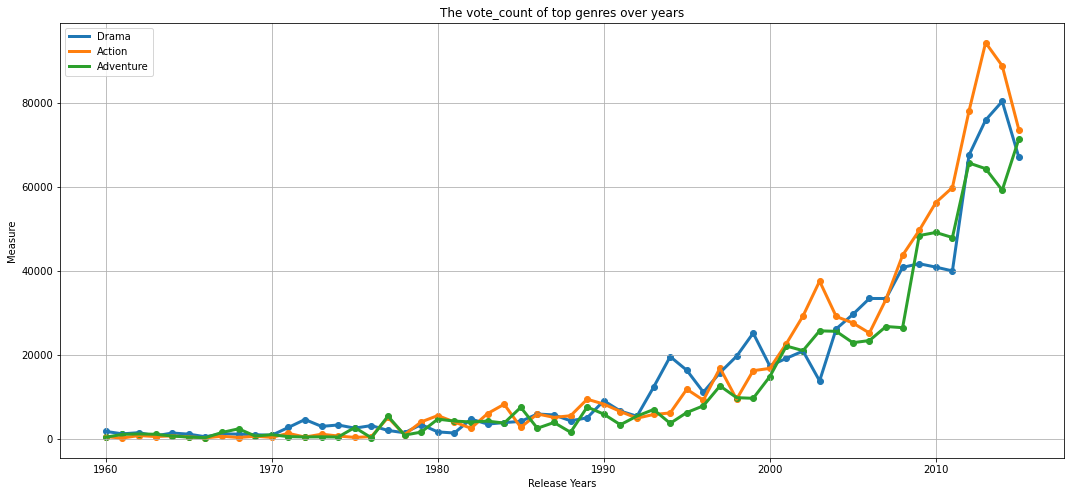

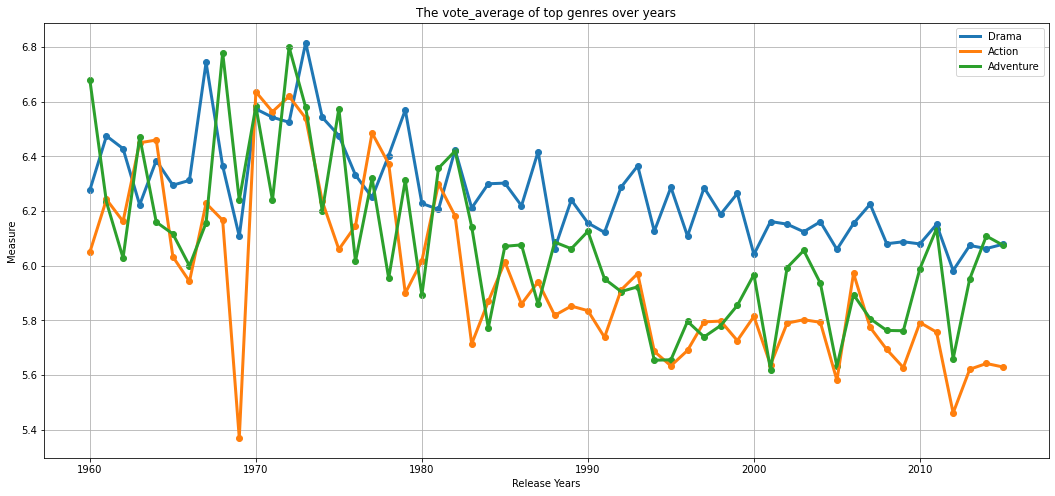

In [379]:
trend_lines('profit')
trend_lines('vote_count', get_top_genres('profit'))
trend_lines('vote_average', get_top_genres('profit'))

<AxesSubplot:xlabel='vote_count', ylabel='profit'>

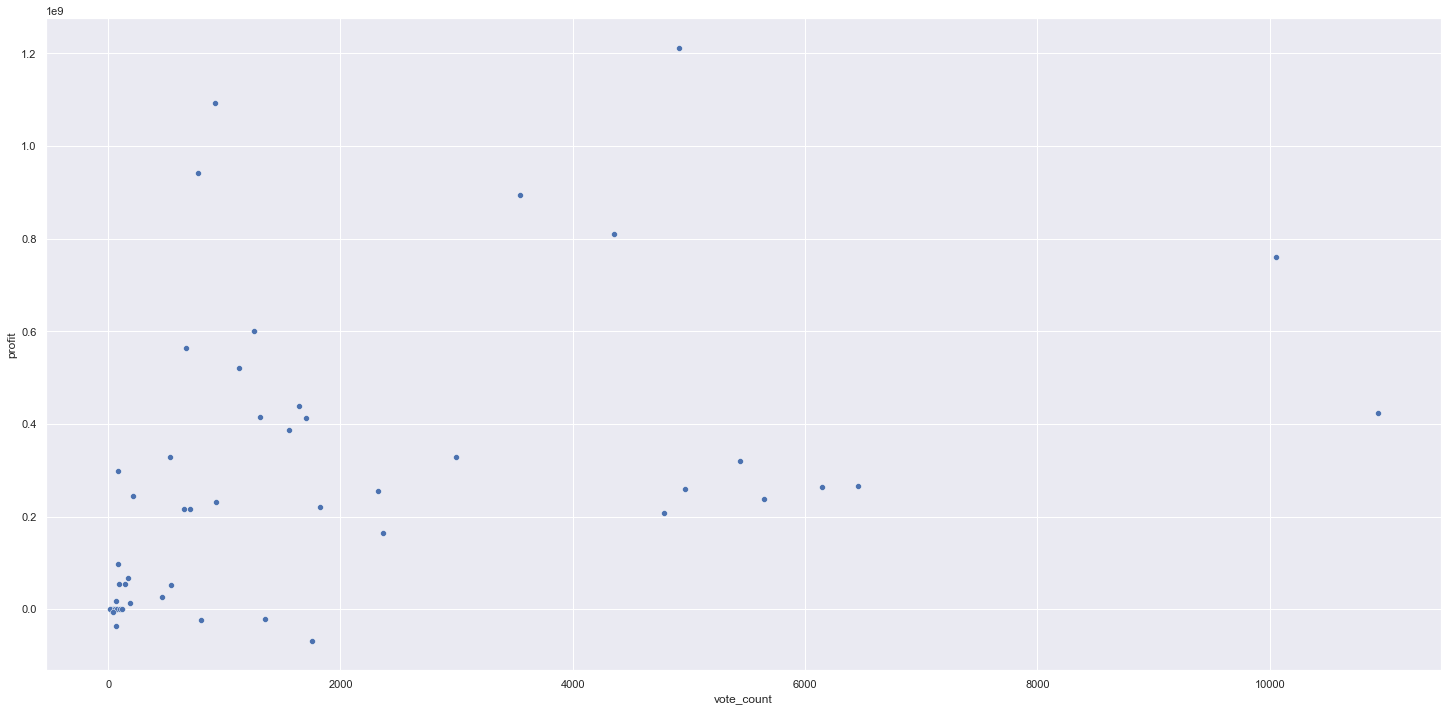

In [14]:
sb.scatterplot(data=df_aggregated[df_aggregated['genres'] == 'Drama'], x='vote_count', y='profit')

In [15]:
df[ (df['genres'] == 'Drama') & (df['release_year'] > 1970) & (df['release_year'] < 1980) ].sort_values(by='profit', ascending= False)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,profit
7833,1367,tt0079817,1.049233,7000000,200182160,Rocky II,Sylvester Stallone|Talia Shire|Burt Young|Carl...,NaN,Sylvester Stallone,Once he fought for a dream. Now he's fighting ...,...,119,Drama,United Artists,1979-06-15,504,6.8,1979,2.103188e+07,6.014581e+08,5.804262e+08
10174,1366,tt0075148,2.389663,1100000,117235147,Rocky,Sylvester Stallone|Talia Shire|Burt Young|Carl...,NaN,John G. Avildsen,His whole life was a million-to-one shot.,...,119,Drama,United Artists,1976-11-21,963,7.2,1976,4.214868e+06,4.492097e+08,4.449948e+08
9805,510,tt0073486,3.258151,3000000,108981275,One Flew Over the Cuckoo's Nest,Jack Nicholson|Louise Fletcher|Danny DeVito|Wi...,NaN,MiloÅ¡ Forman,"If he's crazy, what does that make you?",...,133,Drama,Fantasy Films|Warner Bros.,1975-11-18,1612,8.0,1975,1.215546e+07,4.415726e+08,4.294172e+08
7848,12102,tt0079417,0.416453,8000000,106260000,Kramer vs. Kramer,Dustin Hoffman|Meryl Streep|Jane Alexander|Jus...,NaN,Robert Benton,There are three sides to this love story,...,105,Drama,Columbia Pictures,1979-12-19,240,7.3,1979,2.403643e+07,3.192639e+08,2.952275e+08
9968,36492,tt0066892,0.116440,0,28623900,Carnal Knowledge,Jack Nicholson|Candice Bergen|Art Garfunkel|An...,NaN,Mike Nichols,Everyone needs to be loved - sometime or another.,...,98,Drama,AVCO Embassy Pictures,1971-10-21,11,6.1,1971,0.000000e+00,1.541453e+08,1.541453e+08
9951,25188,tt0067328,0.369308,1300000,29133000,The Last Picture Show,Timothy Bottoms|Jeff Bridges|Cybill Shepherd|B...,http://www.filmsite.org/lastp.html,Peter Bogdanovich,"Anarene, Texas, 1951. Nothing much has changed...",...,118,Drama,Columbia Pictures Corporation|BBS Productions,1971-10-03,42,7.0,1971,7.000753e+06,1.568869e+08,1.498861e+08
10185,10774,tt0074958,0.476406,3800000,23689877,Network,Faye Dunaway|William Holden|Peter Finch|Robert...,NaN,Sidney Lumet,Not since the dawn of time has America experie...,...,121,Drama,United Artists|Metro-Goldwyn-Mayer (MGM),1976-11-01,161,7.4,1976,1.456045e+07,9.077245e+07,7.621200e+07
7879,40842,tt0079638,0.058087,0,22228000,Norma Rae,Sally Field|Beau Bridges|Ron Leibman|Pat Hingl...,NaN,Martin Ritt,The story of a woman with the courage to risk ...,...,110,Drama,Twentieth Century Fox Film Corporation,1979-03-02,13,5.8,1979,0.000000e+00,6.678523e+07,6.678523e+07
9822,22094,tt0073092,0.423755,2700000,5000000,Hard Times,Charles Bronson|James Coburn|Jill Ireland|Stro...,NaN,Walter Hill,"New Orleans, 1933. In those days words didn't ...",...,93,Drama,Columbia Pictures Corporation,1975-09-04,14,5.9,1975,1.093992e+07,2.025911e+07,9.319189e+06
1349,42222,tt0076245,0.398651,0,0,Julia,Jane Fonda|Vanessa Redgrave|Jason Robards|Maxi...,NaN,Fred Zinnemann,"Through It All, Friendship Prevailed.",...,117,Drama,Twentieth Century Fox Film Corporation,1977-10-02,10,5.0,1977,0.000000e+00,0.000000e+00,0.000000e+00


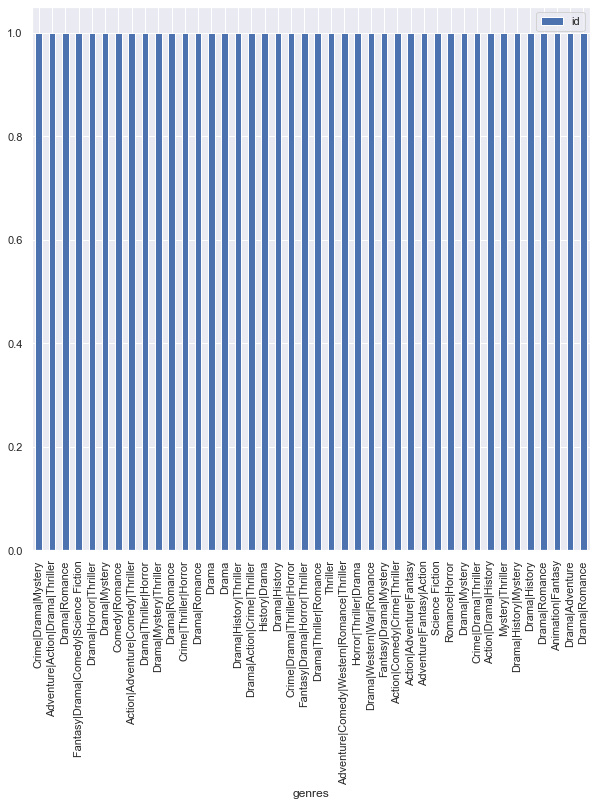

In [16]:
top_genres= df.groupby(['cast', 'genres'])[['id']].nunique().sort_values(['id', 'cast'] , ascending=[False, True])

top_genres.reset_index(inplace= True)

top_genres[top_genres['cast'].str.contains('Anthony Hopkins')].plot.bar(x='genres', figsize=(10,10));

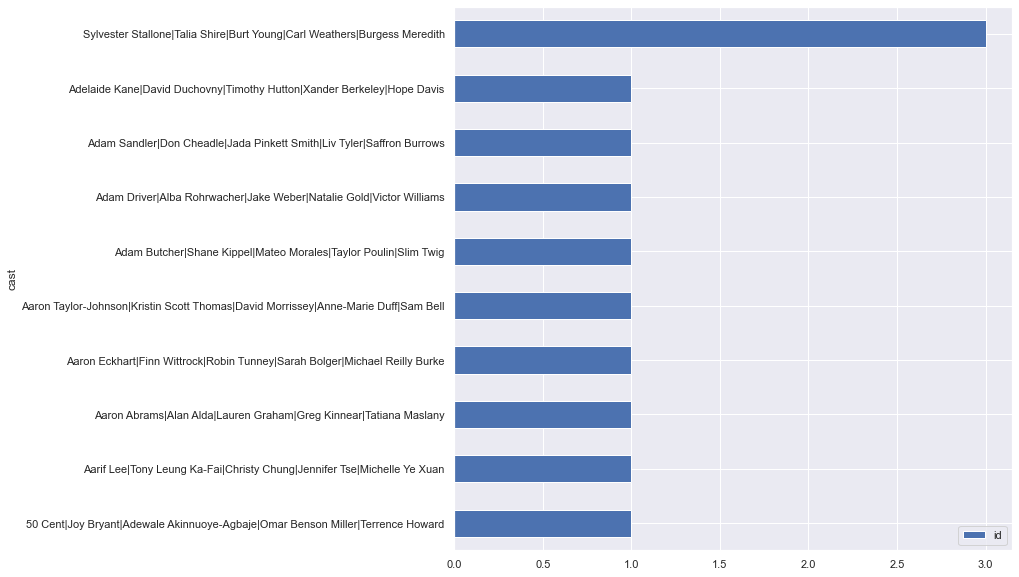

In [17]:
top_genres[top_genres['genres']== 'Drama'].iloc[0:10,:].sort_values('id', ascending=True).plot.barh(x='cast', figsize=(10,10));

In [18]:
d = df.groupby(['release_year', 'cast'])[['id']].count().rename(columns={'id': 'count'})
d
#d.sort_values(by=['release_year', 'cast'], ascending=True).plot.line()

count
release_year cast                                                     
1960         Albert Finney|Shirley Anne Field|Rachel Roberts...      1
             Anthony Perkins|Vera Miles|John Gavin|Janet Lei...      1
             Burt Lancaster|Audrey Hepburn|Audie Murphy|John...      1
             Burt Lancaster|Jean Simmons|Arthur Kennedy|Dean...      1
             Cary Grant|Deborah Kerr|Robert Mitchum|Jean Sim...      1
...                                                                ...
2015         William Shatner|George Buza|Rob Archer|ZoÃ© De ...      1
             Yaya DaCosta|Arlen Escarpeta|Yolanda Ross|Mark ...      1
             Zac Efron|Emily Ratajkowski|Wes Bentley|Nick Ro...      1
             Zooey Deschanel|Aubrey Plaza|Anton Yelchin|Alia...      1
             Zosia Mamet|Jessica Biel|Joe Anderson|Edi Gathe...      1

[10785 rows x 1 columns]